The Tennis Tournament in 2019
-- 

Introduction

- Our group's topic is about the tennis tournaments and players involved. There are many players from different regions with a range of ages competing with each other for the win. The players are ranked based on their capabilities.

- In the data analysis, our group wants to predict that **How is the players' age relating to the winning rate of their matches in all tournaments in 2019**.
  
- The dataset is about the **Game Results for Top 500 Players from 2017-2019** for many tennis tournaments, which contains various tennis players information with their ranks, ages and etc. And for our prediction, we are only containing the **All tournaments** in **2019** for answering the question. We are including the tournament date, winner's age, loser's age and etc. 

New names:
• `` -> `...1`
Rows: 6866 Columns: 50
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (16): tourney_id, tourney_name, surface, tourney_level, winner_seed, win...
dbl (34): ...1, draw_size, tourney_date, match_num, winner_id, winner_ht, wi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age_group,count
<fct>,<int>
15-20,84
20-25,329
25-30,347
30-35,329
35-40,102
40-50,2


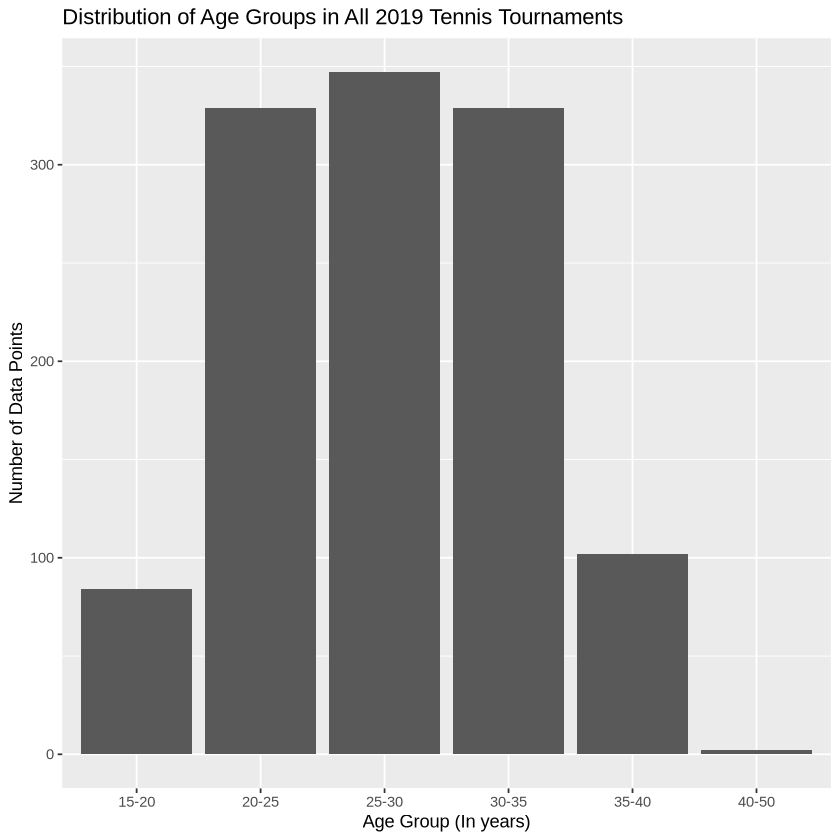

In [30]:
#Premilinary Data Analysis
library(tidyverse)
library(repr)
library(tidymodels)

set.seed(1)
atp <- read_csv("data/atp2017-2019.csv") |>
    select(tourney_name, tourney_date, winner_age) |>
    filter(tourney_date > 2019000) |>
    mutate(winner_age = round(winner_age, 2))

#Eliminating repeated winner_age ages
atp <- atp |>
    group_by(winner_age) |>
    summarize(wins = n())

#Splitting the data
atp_split <- initial_split(atp, prop = 0.75, strata = wins)
atp_train <- (atp_split)
atp_test <- (atp_split)

#Constructing useful table out of training data (age distribution)
age_distribution <- as_tibble(atp_train) |>
    mutate(age_group = cut(winner_age, breaks = c(15, 20, 25, 30, 35, 40, 50),
                           include.lowest = TRUE,
                           labels = c("15-20", "20-25", "25-30", "30-35", "35-40", "40-50"))) |>
    group_by(age_group) |>
    summarize(count = n())
age_distribution

#Age distribution visualization
age_distribution_hist <- ggplot(age_distribution, aes(x = age_group, y = count)) +
    geom_bar(stat = "identity") +
    labs(x = "Age Group (In years)", y = "Number of Data Points") + 
    ggtitle("Distribution of Age Groups in All 2019 Tennis Tournaments")

age_distribution_hist

**Methods**

To investigate the win rates across several age groups in major tennis tournaments in 2019, we will employ a regression model. To do this we will split our data set into a training and a testing set to ensure the accuracy of our model. We will make use of K-nearest neighbours regression to construct a model, train it with a training data set, and then evaluate its performance using data.

For this analysis, we will focus on the following columns from the data set based in 2019: tourney_date, tourney_name, winner_age. Using the predictor variable age,  the regression model will predict the likelihood of a player winning a match based on their age. Then Illustrating the relationship through a histogram.



**Expected outcomes and significance**

We anticipate our regression model will accurately predict the win rates of players across a variety of age groups in major tournaments, including Grand Slams, for tennis. 

Understanding these win rates can provide valuable insights into the performance of athletes in the sport in regard to their age. This model can aid players, coaches, and analysts in strategizing training regimes, player selection, and scheduling.

Future investigations could explore the impact of additional variables to create more accuracy in determining the win rate of an age group such as serve points, and aces with respect to age. Furthermore, extending the set to include other major tournaments in the from several years could a more comprehensive understanding of age-related performance trends in professional tennis.
